In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
df = pd.read_csv('Global_Pollution_Analysis.csv')

# Handle missing data with mean imputation for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Handle outliers by capping values at 1st and 99th percentiles
for col in num_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower, upper)

# Normalize/standardize features (example: CO2 emissions, industrial waste)
features_to_scale = ['CO2_Emissions (in MT)', 'Industrial_Waste (in tons)']  # use actual column names
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Encode categorical features
le_country = LabelEncoder()
le_year = LabelEncoder()
df['Country_encoded'] = le_country.fit_transform(df['Country'])
df['Year_encoded'] = le_year.fit_transform(df['Year'])

# df is now preprocessed and ready for further analysis

In [3]:
# Create new feature: Energy consumption per capita is already present as 'Energy_Consumption_Per_Capita (in MWh)'

# Create new feature: Yearly pollution trend (sum of pollution indices)
df['Total_Pollution_Index'] = (
    df['Air_Pollution_Index'] +
    df['Water_Pollution_Index'] +
    df['Soil_Pollution_Index']
)

# Feature scaling for pollution indices
pollution_features = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index', 'Total_Pollution_Index']
df[pollution_features] = scaler.fit_transform(df[pollution_features])

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Create pollution severity labels based on Total_Pollution_Index quantiles
df['Pollution_Severity'] = pd.qcut(df['Total_Pollution_Index'], q=3, labels=['Low', 'Medium', 'High'])

# Select features for classification (using scaled pollution indices)
X = df[pollution_features]
y = df['Pollution_Severity']

# MultinomialNB requires non-negative features, so shift data if necessary
X_shifted = X - X.min().min()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_shifted, y, test_size=0.2, random_state=42, stratify=y)

# Train Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predict
y_pred = nb.predict(X_test)

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Accuracy:", acc)
print("Confusion Matrix:\n", cm)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.575
Confusion Matrix:
 [[ 7  1  5]
 [ 2  6  5]
 [ 0  4 10]]
Precision: 0.6050505050505051
Recall: 0.575
F1-score: 0.5752005347593583

Classification Report:
               precision    recall  f1-score   support

        High       0.50      0.71      0.59        14
         Low       0.78      0.54      0.64        13
      Medium       0.55      0.46      0.50        13

    accuracy                           0.57        40
   macro avg       0.61      0.57      0.57        40
weighted avg       0.61      0.57      0.58        40



In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for K (number of neighbors)
param_grid = {'n_neighbors': list(range(1, 21))}
knn = KNeighborsClassifier()

# Use GridSearchCV to find the best K
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Optimal number of neighbors (K): {best_k}")

# Train KNN with the best K
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

# Predict
y_pred_knn = knn_best.predict(X_test)

# Evaluation metrics
acc_knn = accuracy_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=['Low', 'Medium', 'High'])
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)

print("KNN Accuracy:", acc_knn)
print("KNN Confusion Matrix:\n", cm_knn)
print("KNN Precision:", precision_knn)
print("KNN Recall:", recall_knn)
print("KNN F1-score:", f1_knn)
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred_knn, zero_division=0))

Optimal number of neighbors (K): 18
KNN Accuracy: 0.9
KNN Confusion Matrix:
 [[12  1  0]
 [ 0 11  2]
 [ 0  1 13]]
KNN Precision: 0.9033333333333333
KNN Recall: 0.9
KNN F1-score: 0.9007931034482759

KNN Classification Report:
               precision    recall  f1-score   support

        High       0.87      0.93      0.90        14
         Low       1.00      0.92      0.96        13
      Medium       0.85      0.85      0.85        13

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Set up parameter grid for hyperparameter tuning
dt_param_grid = {
    'max_depth': list(range(2, 11)),
    'min_samples_split': [2, 5, 10, 20]
}

dt = DecisionTreeClassifier(random_state=42)
dt_grid_search = GridSearchCV(dt, dt_param_grid, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)

best_dt = dt_grid_search.best_estimator_
print(f"Best parameters: {dt_grid_search.best_params_}")

# Train and predict
best_dt.fit(X_train, y_train)
y_pred_dt = best_dt.predict(X_test)

# Evaluation metrics
acc_dt = accuracy_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=['Low', 'Medium', 'High'])
precision_dt = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall_dt = recall_score(y_test, y_pred_dt, average='weighted', zero_division=0)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted', zero_division=0)

print("Decision Tree Accuracy:", acc_dt)
print("Decision Tree Confusion Matrix:\n", cm_dt)
print("Decision Tree Precision:", precision_dt)
print("Decision Tree Recall:", recall_dt)
print("Decision Tree F1-score:", f1_dt)
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt, zero_division=0))

Best parameters: {'max_depth': 2, 'min_samples_split': 2}
Decision Tree Accuracy: 0.975
Decision Tree Confusion Matrix:
 [[13  0  0]
 [ 0 13  0]
 [ 0  1 13]]
Decision Tree Precision: 0.9767857142857143
Decision Tree Recall: 0.975
Decision Tree F1-score: 0.975

Decision Tree Classification Report:
               precision    recall  f1-score   support

        High       1.00      0.93      0.96        14
         Low       1.00      1.00      1.00        13
      Medium       0.93      1.00      0.96        13

    accuracy                           0.97        40
   macro avg       0.98      0.98      0.98        40
weighted avg       0.98      0.97      0.97        40



           Model  Accuracy  Precision  Recall  F1-score
0  MultinomialNB     0.575   0.605051   0.575  0.575201
1            KNN     0.900   0.903333   0.900  0.900793
2  Decision Tree     0.975   0.976786   0.975  0.975000


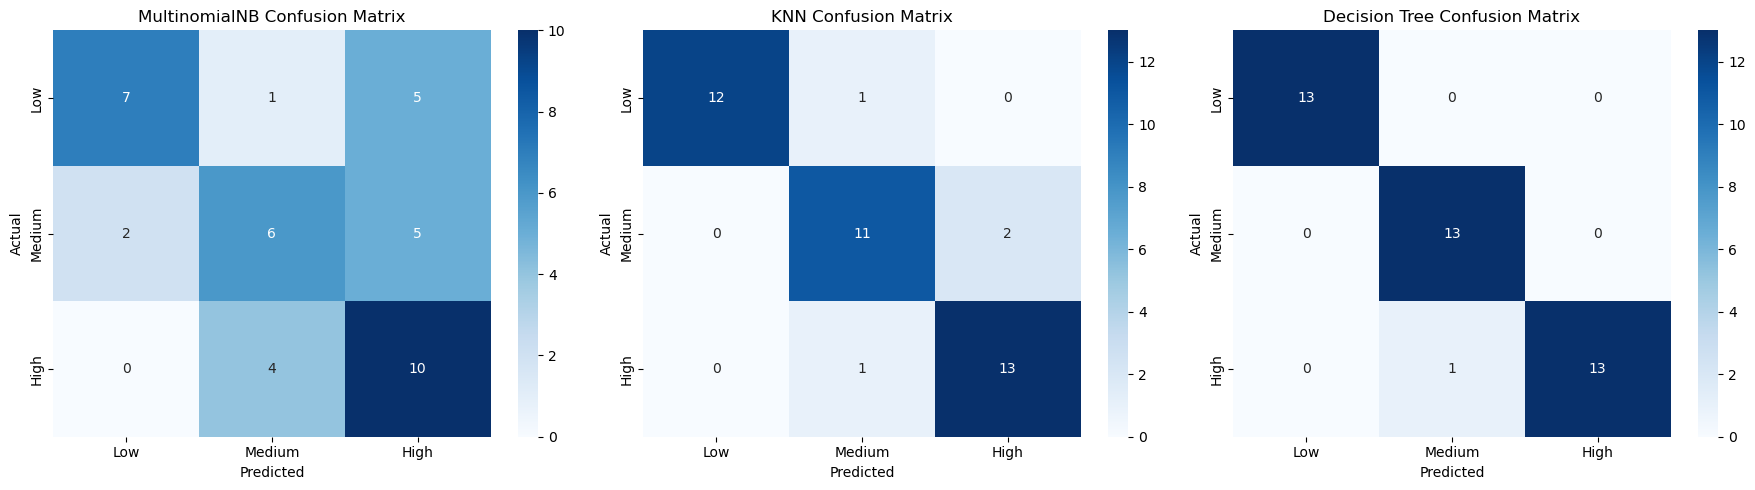


Classification Report for MultinomialNB:

              precision    recall  f1-score   support

        High       0.50      0.71      0.59        14
         Low       0.78      0.54      0.64        13
      Medium       0.55      0.46      0.50        13

    accuracy                           0.57        40
   macro avg       0.61      0.57      0.57        40
weighted avg       0.61      0.57      0.58        40


Classification Report for KNN:

              precision    recall  f1-score   support

        High       0.87      0.93      0.90        14
         Low       1.00      0.92      0.96        13
      Medium       0.85      0.85      0.85        13

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40


Classification Report for Decision Tree:

              precision    recall  f1-score   support

        High       1.00      0.93      0.96        14
         L

In [7]:
import seaborn as sns

import matplotlib.pyplot as plt

# Prepare data for comparison
models = ['MultinomialNB', 'KNN', 'Decision Tree']
accuracies = [acc, acc_knn, acc_dt]
precisions = [precision, precision_knn, precision_dt]
recalls = [recall, recall_knn, recall_dt]
f1_scores = [f1, f1_knn, f1_dt]
cms = [cm, cm_knn, cm_dt]
y_preds = [y_pred, y_pred_knn, y_pred_dt]

# Print metrics comparison
metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-score': f1_scores
})
print(metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axes):
    sns.heatmap(cms[i], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Low', 'Medium', 'High'], 
                yticklabels=['Low', 'Medium', 'High'], ax=ax)
    ax.set_title(f'{models[i]} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Print classification reports
for i, model in enumerate(models):
    print(f"\nClassification Report for {model}:\n")
    print(classification_report(y_test, y_preds[i], zero_division=0))

In [8]:
# Model Comparison

print("Model Performance Comparison:\n")
print(metrics_df)

print("\nConfusion Matrices:")
for i, model in enumerate(models):
    print(f"\n{model} Confusion Matrix:\n{cms[i]}")

print("\nDetailed Classification Reports:")
for i, model in enumerate(models):
    print(f"\nClassification Report for {model}:\n")
    print(classification_report(y_test, y_preds[i], zero_division=0))

Model Performance Comparison:

           Model  Accuracy  Precision  Recall  F1-score
0  MultinomialNB     0.575   0.605051   0.575  0.575201
1            KNN     0.900   0.903333   0.900  0.900793
2  Decision Tree     0.975   0.976786   0.975  0.975000

Confusion Matrices:

MultinomialNB Confusion Matrix:
[[ 7  1  5]
 [ 2  6  5]
 [ 0  4 10]]

KNN Confusion Matrix:
[[12  1  0]
 [ 0 11  2]
 [ 0  1 13]]

Decision Tree Confusion Matrix:
[[13  0  0]
 [ 0 13  0]
 [ 0  1 13]]

Detailed Classification Reports:

Classification Report for MultinomialNB:

              precision    recall  f1-score   support

        High       0.50      0.71      0.59        14
         Low       0.78      0.54      0.64        13
      Medium       0.55      0.46      0.50        13

    accuracy                           0.57        40
   macro avg       0.61      0.57      0.57        40
weighted avg       0.61      0.57      0.58        40


Classification Report for KNN:

              precision    recall

In [9]:
# Policy Recommendations Based on Model Insights

# Analyze feature importance from the best decision tree model
if hasattr(best_dt, "feature_importances_"):
    feature_importance = pd.Series(best_dt.feature_importances_, index=pollution_features)
    print("Feature Importances from Decision Tree:\n", feature_importance.sort_values(ascending=False))

    # Identify the most influential pollution factors
    top_features = feature_importance.sort_values(ascending=False).index.tolist()
else:
    top_features = pollution_features  # fallback

# Generate policy recommendations based on top features
policy_recommendations = []

if 'Air_Pollution_Index' in top_features[:2]:
    policy_recommendations.append(
        "Implement stricter air quality regulations, promote clean energy adoption, and incentivize reduction of industrial emissions."
    )
if 'Water_Pollution_Index' in top_features[:2]:
    policy_recommendations.append(
        "Enhance wastewater treatment, regulate industrial discharge, and promote sustainable agricultural practices to reduce water pollution."
    )
if 'Soil_Pollution_Index' in top_features[:2]:
    policy_recommendations.append(
        "Control use of hazardous chemicals, improve waste management, and encourage soil remediation projects."
    )
if 'Total_Pollution_Index' in top_features[:2]:
    policy_recommendations.append(
        "Adopt integrated pollution management strategies targeting multiple sources simultaneously for maximum impact."
    )

print("\nPolicy Recommendations for Reducing Pollution:")
for rec in policy_recommendations:
    print("-", rec)

Feature Importances from Decision Tree:
 Total_Pollution_Index    1.0
Air_Pollution_Index      0.0
Water_Pollution_Index    0.0
Soil_Pollution_Index     0.0
dtype: float64

Policy Recommendations for Reducing Pollution:
- Implement stricter air quality regulations, promote clean energy adoption, and incentivize reduction of industrial emissions.
- Adopt integrated pollution management strategies targeting multiple sources simultaneously for maximum impact.
